In [1]:
import sys
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers
from plotly_functions import *
%config InlineBackend.figure_formats = ['svg']

print("Python version:", sys.version[:5])
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", mpl.__version__)
print("Tensorflow version:", tf.__version__)

Python version: 3.6.8
Numpy version: 1.16.4
Pandas version: 0.25.1
Matplotlib version: 3.1.1
Tensorflow version: 1.14.0


## Quick overview of the data

#### Read the data

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
    
print("Train dataset shape:", train.shape)
print("Test dataset shape:", test.shape)
print("Train/test dataset ratio:", round(train.shape[0]/test.shape[0], 2))

del test

Train dataset shape: (1460, 81)
Test dataset shape: (1459, 80)
Train/test dataset ratio: 1.0


#### Read data description from "data_description.txt" file

In [3]:
with open("data_description.txt") as file:
    data_description = file.readlines()
    
columns = train.columns

# make a dictionary of columns as keys and descriptions as values
col_descriptions= dict()
for row in data_description:
    for col in columns:
        if col in row:
            try:
                col_description = row.split(":")[1]
                #print("col descrp", col_description)
                col_descriptions[col] = col_description.strip("\n")
            except:
                col_descriptions[col] = ""

# assign empty string to columns that are not described in the "data_description.txt" file
for column in columns:
    if column not in col_descriptions.keys():
        col_descriptions[column]=""

#### Overview of the numeric data

In [4]:
num_data = train._get_numeric_data()
df_num = pd.DataFrame(index = num_data.columns,
    data=dict(
        Col_description=[col_descriptions.get(key) for key in num_data.columns],
        Min=num_data.min(),
        Max=num_data.max(),
    )
)
pd.set_option('display.max_colwidth', 50)
df_num = df_num.style.set_properties(**{'text-align': 'left'})
df_num

,Col_description,Min,Max
Id,Identifies the general zoning classification of the sale.,1,1460
MSSubClass,Identifies the type of dwelling involved in the sale.,20,190
LotFrontage,Linear feet of street connected to property,21,313
LotArea,Lot size in square feet,1300,215245
OverallQual,Rates the overall material and finish of the house,1,10
OverallCond,Rates the overall condition of the house,1,9
YearBuilt,Original construction date,1872,2010
YearRemodAdd,Remodel date (same as construction date if no remodeling or additions),1950,2010
MasVnrArea,Masonry veneer area in square feet,0,1600
BsmtFinSF1,Type 1 finished square feet,0,5644


#### Overview of the categorical data

In [5]:
cat_columns = [col for col in train.columns if col not in num_data.columns]

unique_values = []
for col in cat_columns:
    unique_values.append([str(val) for val in train[col].unique()])

df_cat = pd.DataFrame(
    index = cat_columns,
    data = dict(
        Col_description=[col_descriptions.get(key) for key in cat_columns],
        Unique_values = [", ".join(row) for row in unique_values] 
    )
)
pd.set_option('display.max_colwidth', 50)
df_cat = df_cat.style.set_properties(**{'text-align': 'left'})
df_cat

,Col_description,Unique_values
MSZoning,Identifies the general zoning classification of the sale.,"RL, RM, C (all), FV, RH"
Street,Type of road access to property,"Pave, Grvl"
Alley,Type of alley access to property,"nan, Grvl, Pave"
LotShape,General shape of property,"Reg, IR1, IR2, IR3"
LandContour,Flatness of the property,"Lvl, Bnk, Low, HLS"
Utilities,,"AllPub, NoSeWa"
LotConfig,Lot configuration,"Inside, FR2, Corner, CulDSac, FR3"
LandSlope,Slope of property,"Gtl, Mod, Sev"
Neighborhood,Physical locations within Ames city limits,"CollgCr, Veenker, Crawfor, NoRidge, Mitchel, Somerst, NWAmes, OldTown, BrkSide, Sawyer, NridgHt, NAmes, SawyerW, IDOTRR, MeadowV, Edwards, Timber, Gilbert, StoneBr, ClearCr, NPkVill, Blmngtn, BrDale, SWISU, Blueste"
Condition1,Proximity to various conditions,"Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, PosA, RRNe"


#### Check for Nan values

In [6]:
nans = train.isna().sum().sort_index()
nans = nans.loc[nans!=0]

df_nan = pd.DataFrame(
    index = nans.index,
    data={
        "Nan_Count" : nans.values,
        "NaN(%)" : np.round(100*nans.values/len(train), 2),
        "Type" : ["Categorical" if col in cat_columns else "Numerical" for col in nans.index]
    }
)
df_nan = df_nan.style.set_properties(**{'text-align': 'left'})
df_nan

,Nan_Count,NaN(%),Type
Alley,1369,93.77,Categorical
BsmtCond,37,2.53,Categorical
BsmtExposure,38,2.6,Categorical
BsmtFinType1,37,2.53,Categorical
BsmtFinType2,38,2.6,Categorical
BsmtQual,37,2.53,Categorical
Electrical,1,0.07,Categorical
Fence,1179,80.75,Categorical
FireplaceQu,690,47.26,Categorical
GarageCond,81,5.55,Categorical


## Feature Engineering

#### Handle missing values

In [7]:
if "Id" in train.columns:
    train = train.drop(columns=["Id"])
    num_data = num_data.drop(columns=["Id"])

train["GarageYrBlt"].fillna(train["GarageYrBlt"].median(), inplace=True)
train["LotFrontage"].fillna(0, inplace=True)
train["MasVnrArea"].fillna(0, inplace=True)

#### Handle numerical and categorical features

In [8]:
# Although MSSubClass looks like a numerical, it is actually categorical feature
train["MSSubClass"] = ["MS Class: " + str(i) for i in train["MSSubClass"].values]

# column 'MoSold' should be also treated as categorical feature
months_abbr = {
    "1": "Jan.",
    "2": "Feb.",
    "3": "Mar.",
    "4": "Apr.",
    "5": "May",
    "6": "Jun.",
    "7": "Jul.",
    "8": "Aug.",
    "9": "Sept.",
    "10": "Oct.",
    "11": "Nov.",
    "12": "Dec.",
}
train["MoSold"] = [months_abbr[str(i)] for i in train["MoSold"].values]

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

base_grades = {
    "Po":1,
    "Fa":2,
    "TA":3,
    "Gd": 4,
    "Ex":5,
}

basement_grades = {
       "Unf":1,
       "LwQ":2,
       "Rec":3,
       "BLQ":4,
       "ALQ":5,
       "GLQ":6,
}

utilites_grades = {
    "ELO":1,
    "NoSeWa":2,
    "NoSewr":3,
    "AllPub":4,
}

garage_grades = {
    "Unf":1,
    "RFn":2,
    "Fin":3
}

grading_categories = []
for col in cat_columns:
    if "Gd" in train[col].unique() and "TA" in train[col].unique():
        train[col] = [base_grades[key] if type(key)!=float else 0 for key in train[col]]
        grading_categories.append(col)

train["Utilities"] = [utilites_grades[key] if type(key)!=float else 0 for key in train["Utilities"]]
train["BsmtFinType1"] = [basement_grades[key] if type(key)!=float else 0 for key in train["BsmtFinType1"]]
train["BsmtFinType2"] = [basement_grades[key] if type(key)!=float else 0 for key in train["BsmtFinType2"]]
train["GarageFinish"] = [garage_grades[key] if type(key)!=float else 0 for key in train["GarageFinish"]]

In [10]:
# add new features

# total area

train["TotalSurface"] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
train["RoomsPerArea"] = train["TotalSurface"]/(train["TotRmsAbvGrd"] + 1)

train["BathroomsRoomsRation"] = train["TotRmsAbvGrd"]/(train["FullBath"] + train["HalfBath"] + 1)
train["LotBsmtRation"] = train["LotArea"]/(train['TotalBsmtSF'] + 1) 

train["OverallQualCond"] = train["OverallQual"]*train["OverallCond"]


#### Feature engineering methods

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

class FeatureEngineering(BaseEstimator, TransformerMixin):
    """
    Problem1: kada se fit metoda koristi na train setom a transform nad test setom jer se mogu javiti razlicite
    jedinstvene vrednosti u ovim setovima sto nakon primene one-hot encodinga dovodi do javljanja novih
    kolona
    """
    
    def __init__(self, scaling="normalize", relevant_features=0, one_hot_encoding = True, drop_encoded_columns=True,
                outliers_std_drop=0):
        self.relevant_features = relevant_features
        self.scaling = scaling
        self.drop_encoded_columns = drop_encoded_columns
        self.one_hot_encoding = one_hot_encoding
        self.outliers_std_drop = outliers_std_drop

    def fit(self, X, y):
        # initial numerical and categorical columns (before one-hot encoding and relevant features modules are applied)
        self.num_columns_init = X._get_numeric_data().columns
        self.cat_columns_init = [col for col in X.columns if col not in self.num_columns_init]
        print("Initial number of categorical columns:", len(self.cat_columns_init))
        print("Initial number of numerical columns:", len(self.num_columns_init))
        
        if self.one_hot_encoding:
            X = self.one_hot_encoding_(X)
            self.onehot_columns = X.columns
            print("Number of (numerical) columns after One-hot encoding is applied:", X.shape[1])
        
        if self.relevant_features:
            y_corr = X.join(y).corr()[y.columns[0]]
            sorted_corr_values = sorted(y_corr.values, reverse=True, key= lambda x: abs(x))[1: self.relevant_features+1]
            sorted_corrs = y_corr.isin(sorted_corr_values)
            self.most_relevant_features = y_corr.loc[sorted_corrs].index
        
        if self.scaling=="normalize":
            self.mms = MinMaxScaler()
            self.mms.fit(X.values)
        
        elif self.scaling=="standardize":
            self.sc = StandardScaler()
            self.sc.fit(X.values)
            
        return self
            
    
    def transform(self, X, y):
        X_transformed = X.copy()
        X_transformed_columns = X_transformed.columns
        
        if self.outliers_std_drop:
            X_transformed, y = self.drop_outliers(X_transformed, y, self.outliers_std_drop)
            
        
        if self.one_hot_encoding:
            X_transformed = self.one_hot_encoding_(X_transformed)
            for col in self.onehot_columns:
                if col not in X_transformed.columns:
                    X_transformed[col] = 0
            for col in X_transformed.columns:
                if col not in self.onehot_columns:
                    X_transformed.drop(columns=[col], inplace=True)
                    
            print("Test set num of columns", X_transformed.shape[1])

            
        if self.scaling=="normalize":
            X_transformed = self.mms.transform(X_transformed)
            X_transformed = pd.DataFrame(X_transformed, columns=self.onehot_columns)
            
        elif self.scaling=="standardize":
            X_transformed = self.sc.transform(X_transformed)
            X_transformed = pd.DataFrame(X_transformed, columns=self.onehot_columns)
            
        if self.relevant_features:
            X_transformed = X_transformed[self.most_relevant_features]
            
        return X_transformed, y
            
    def one_hot_encoding_(self, X):
        one_hot = pd.get_dummies(X[self.cat_columns_init])
        X = X.join(one_hot)
        if self.drop_encoded_columns:
            X.drop(columns = self.cat_columns_init, inplace=True)
        return X
    
    def drop_outliers(self, X, y, std_num=5):
        outliers_count = 0
        float_features = X.select_dtypes(include=[np.float64]).columns
        for column in float_features:
            column_std = X[column].std()
            column_mean = X[column].mean()
            outliers = X[column].loc\
            [(X[column]> column_mean + std_num*column_std) | (X[column] < column_mean - std_num*column_std)]
            outliers_count += len(outliers)
            X = X.drop(index=outliers.index)
            y = y.drop(index=outliers.index)
        print("Number of outliers dropped", outliers_count)
        return X, y

## Data Exploration and Visualization

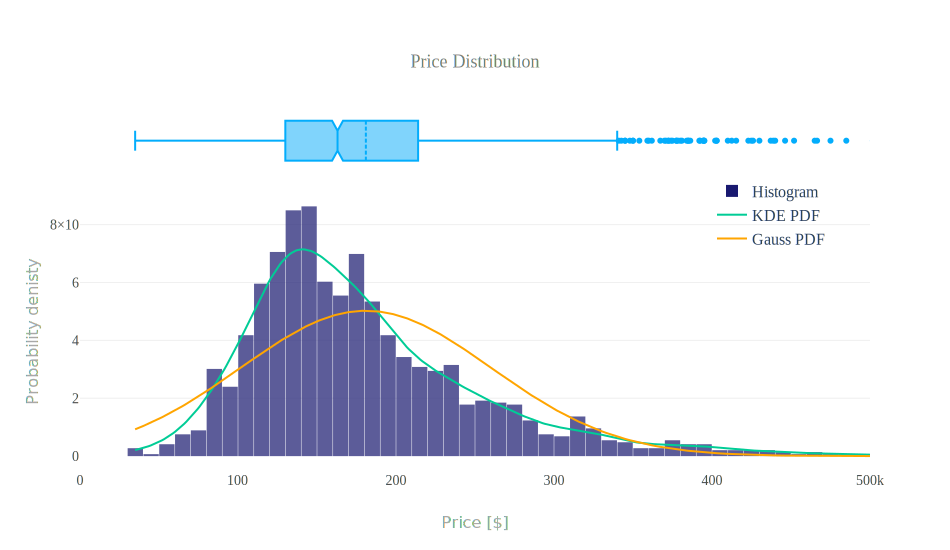

In [12]:
fig = plot_distplot(
    train, 
    "SalePrice", 
    kde_resolution= 512, 
    range_= (0, 5e5), 
    n_bins=86, 
    show_box=True, 
    x_legend=0.8, 
    points="outliers"
)
range_ = [0,5e5]
fig.update_layout(
    title=title_layout("Price Distribution", color="grey", title_size=18),
    xaxis=axis_layout(range_ = range_, showticklabels=False),
    xaxis2=axis_layout("Price [$]", show_exponent="last", range_=range_),
    yaxis2=axis_layout("Probability denisty", exponent_format="power", show_exponent="last", title_size=16, show_grid=True)
)
fig.show(renderer="svg", width=950, height=550,)

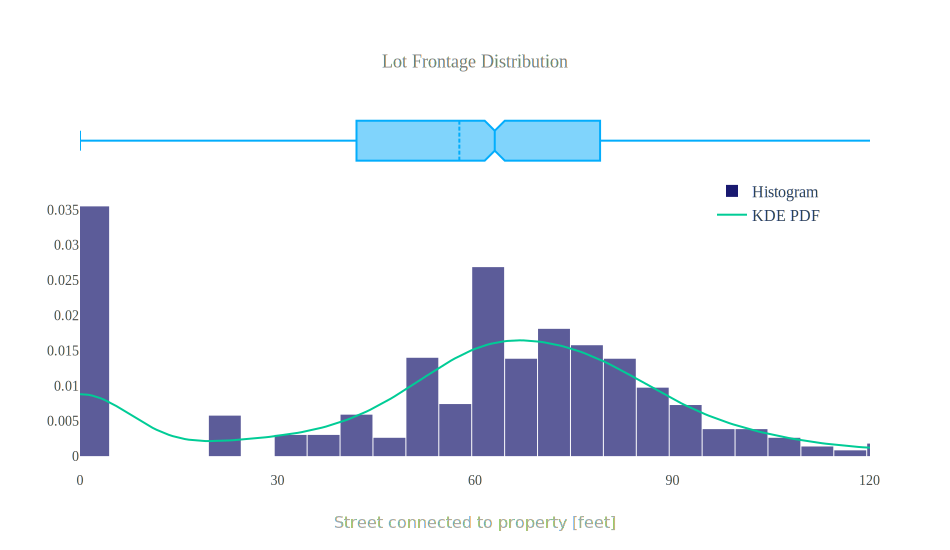

In [13]:
fig = plot_distplot(
    train, 
    "LotFrontage", 
    gauss=False,
    kde_resolution= 512, 
    n_bins=86, 
    show_box=True, 
    x_legend=0.8, 
    points="outliers"
)
fig.update_layout(
    title=title_layout("Lot Frontage Distribution", color="grey", title_size=18),
    xaxis2=axis_layout("Street connected to property [feet]", dtick=30, range_=[0,120]),
    xaxis=axis_layout(showticklabels=False, range_=[0,120])
)
fig.show(renderer="svg", width=950, height=550,)

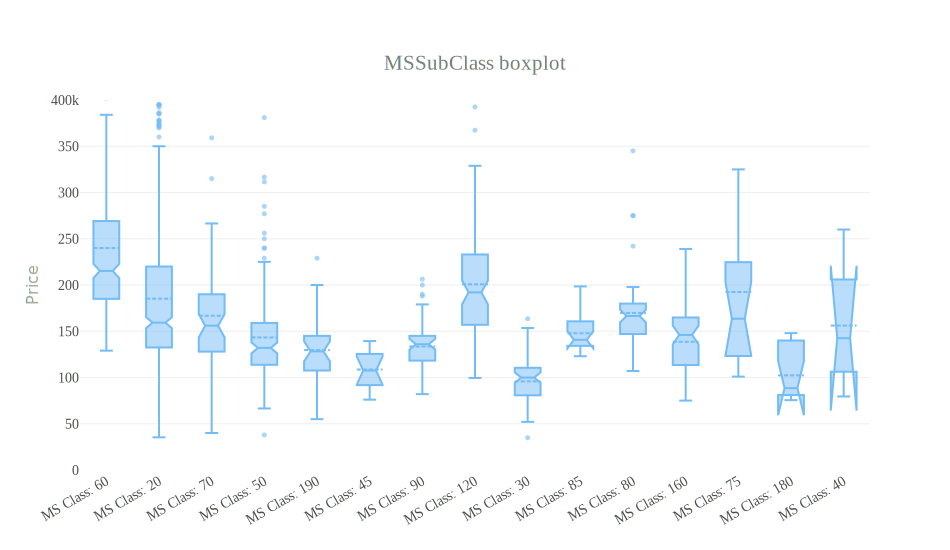

In [14]:
cca = [str(i) for i in train["MSSubClass"].unique()]
fig = plot_box(train, "SalePrice", "MSSubClass", main_categories = train["MSSubClass"].unique())
fig.update_layout(
    title = title_layout("MSSubClass boxplot", color="grey"),
    yaxis = axis_layout(title="Price", ticks="", show_exponent="last", show_grid=True, range_ = [0,4e5]),
    xaxis = axis_layout(tick_angle=-30)
)
fig.show(renderer="svg", width=950, height=550,)

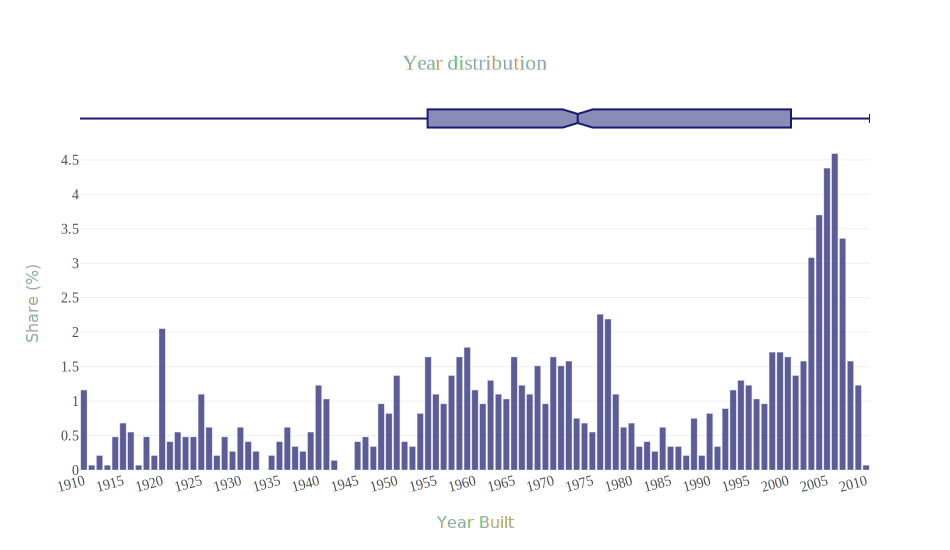

In [15]:
fig = plot_histograms(
    train, 
    "YearBuilt", 
    np.arange(1910, 2011, 1), 
    show_box=True,
    percentage=True, 
    percentage_relative_to="total",
    mean=False,
)
fig.update_layout(
    title=title_layout("Year distribution"),
    xaxis2=axis_layout("Year Built", dtick=5, tick_angle=-15),
    yaxis2=axis_layout("Share (%)", dtick=0.5, show_grid=True)
)

fig.show(renderer="svg", width=950, height=550,)

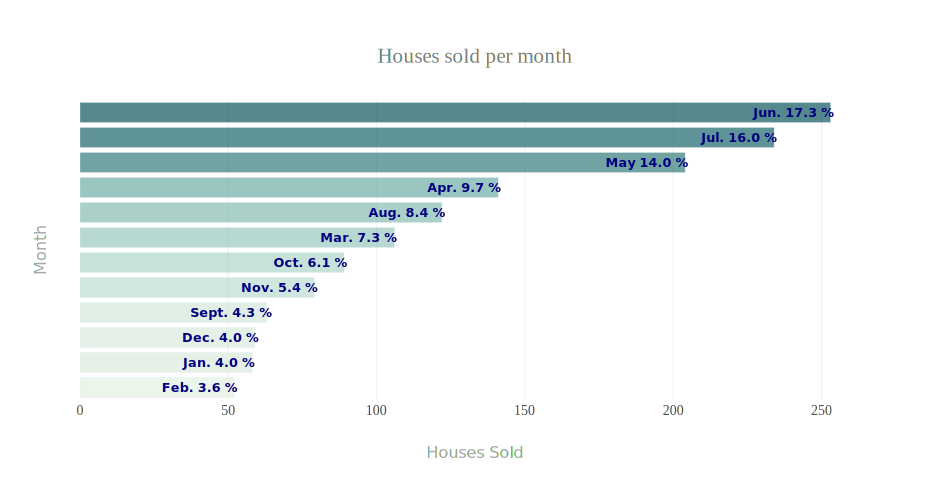

In [16]:
fig = plot_horizontal_count_bars(train, "MoSold", 
                                 show_percentage=True, 
                                 colorscale="mint",
                                )
fig.update_layout(
    title = title_layout("Houses sold per month", color="grey"),
    xaxis=axis_layout("Houses Sold", show_grid=True), 
    yaxis=axis_layout("Month", showticklabels=False),
)
fig.show(renderer="svg", width=950, height=480)

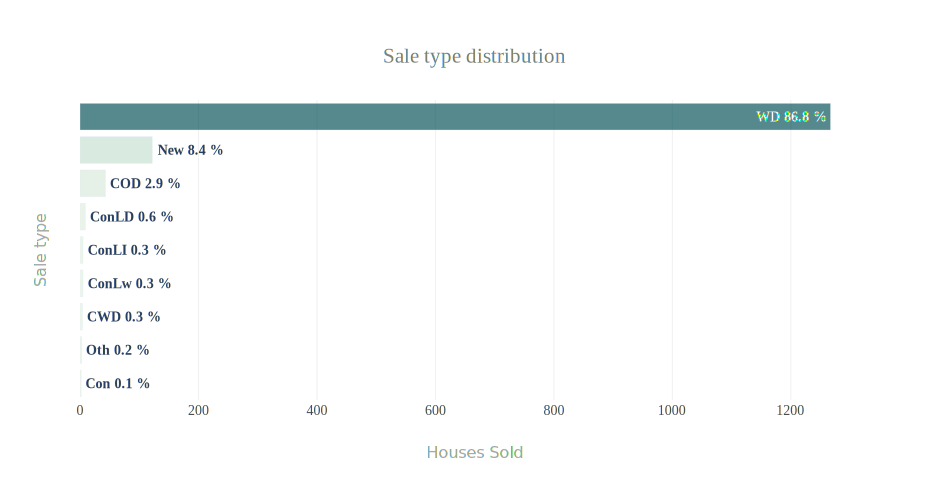

In [35]:
fig = plot_horizontal_count_bars(
    train, "SaleType", 
    show_percentage=True, 
    colorscale="mint",
    text_position="auto",
    text_font={
        "family": "Times New Roman",
        "size": 14
    }
)

fig.update_layout(
    title = title_layout("Sale type distribution", color="grey"),
    xaxis=axis_layout("Houses Sold", show_grid=True), 
    yaxis=axis_layout("Sale type", showticklabels=False),
)
fig.show(renderer="svg", width=950, height=480)

#### Features most correlated with sale price

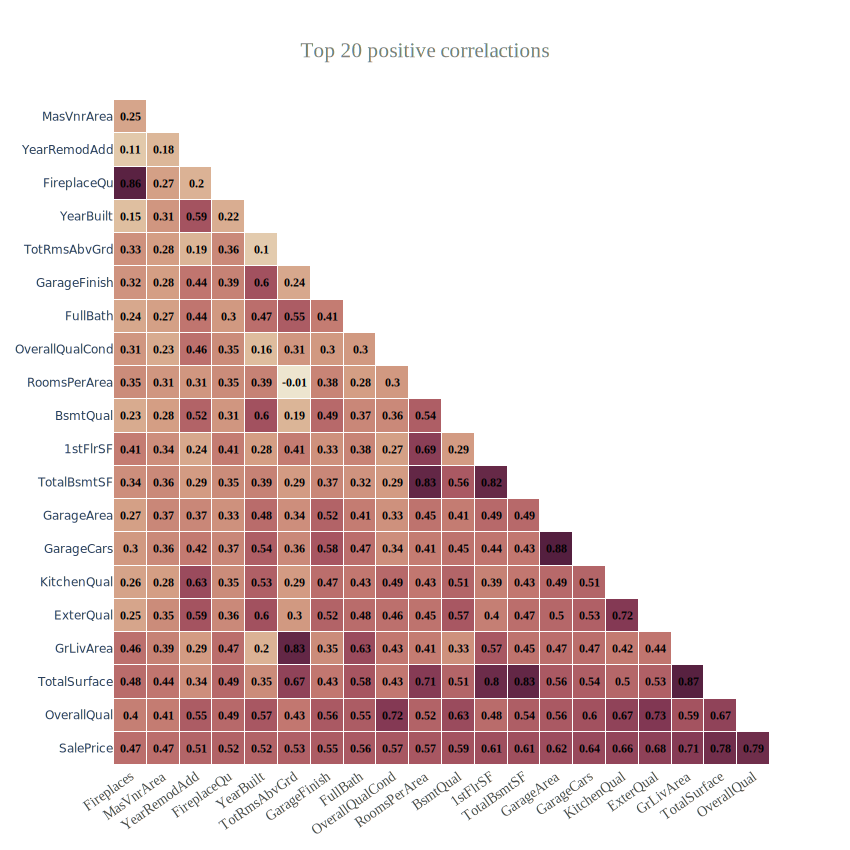

In [17]:
num_data = train._get_numeric_data()
corr_mat = num_data.corr()
corr_price = corr_mat["SalePrice"]

relevant_columns = list(corr_price.sort_values()[-21:].index)

corr_mat = num_data[relevant_columns].corr()

fig = plot_heatmap(corr_mat, text_size=12, plot_triangle=True, showscale=False)
fig.update_layout(
    title=title_layout("Top 20 positive correlactions", color="grey", y_position=0.95),
    xaxis=axis_layout(tick_angle=-35)
)
fig.show(renderer = "svg", width = 850, height =850)

## Building and Fitting a Model. Price prediciton.

In [18]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.losses import mean_squared_logarithmic_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tensorflow.keras import backend as K


def build_model(dropout, optimizer, input_shape, neurons = 10):
    model = models.Sequential(
            layers=[
                layers.Dense(2**(neurons-1), activation="relu", kernel_initializer="glorot_normal",
                             input_shape=(input_shape, )
                            ),
                layers.Dropout(dropout),
                layers.Dense(2**neurons, activation="relu", kernel_initializer="glorot_normal"),
                layers.Dropout(dropout),
                layers.Dense(2**(neurons-1), activation="relu", kernel_initializer="glorot_normal"),
                layers.Dense(1)
            ]
        )
    
    def RMSLE(y_pred, y_true):
        return K.sqrt(K.mean(K.square(tf.log1p(y_true) - tf.log1p(y_pred))))
    
    model.compile(optimizer = optimizer, loss=RMSLE, metrics=["mae"])
    return model

#### Make a train and test datasets

In [19]:
#preprocess = FeatureEngineering(y, relevant_features=128)
#X = preprocess.fit_transform(X, y)
#X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.1)

#### Train the model

In [28]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

n_features = 212
preprocess = FeatureEngineering(relevant_features=n_features, outliers_std_drop=4)
X, y = train.drop(columns=["SalePrice"]), train[["SalePrice"]]
preprocess.fit(X, y)
X_transformed, y = preprocess.transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.1)
model = build_model(dropout=0.15, optimizer="RMSprop", input_shape=n_features, neurons=10)

for i in range(100):
    num_epochs = 5
    model.fit(X_train, y_train, epochs = num_epochs, verbose=0)
    rmsle, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Epoch {(i+1)*num_epochs: > 3.0f}:  RMSLE = {rmsle: .3f} | MAE = {mae: .0f}\n")

Epoch   5:  RMSLE =  0.122 | MAE =  16335

Epoch  10:  RMSLE =  0.108 | MAE =  14073

Epoch  15:  RMSLE =  0.110 | MAE =  14194

Epoch  20:  RMSLE =  0.113 | MAE =  14949

Epoch  25:  RMSLE =  0.114 | MAE =  15197

Epoch  30:  RMSLE =  0.104 | MAE =  13509

Epoch  35:  RMSLE =  0.111 | MAE =  14624

Epoch  40:  RMSLE =  0.110 | MAE =  14211

Epoch  45:  RMSLE =  0.116 | MAE =  15488

Epoch  50:  RMSLE =  0.110 | MAE =  14376

Epoch  55:  RMSLE =  0.116 | MAE =  15468

Epoch  60:  RMSLE =  0.107 | MAE =  13868

Epoch  65:  RMSLE =  0.118 | MAE =  15698

Epoch  70:  RMSLE =  0.108 | MAE =  14158

Epoch  75:  RMSLE =  0.113 | MAE =  14979

Epoch  80:  RMSLE =  0.112 | MAE =  14916

Epoch  85:  RMSLE =  0.108 | MAE =  13751

Epoch  90:  RMSLE =  0.108 | MAE =  13737

Epoch  95:  RMSLE =  0.107 | MAE =  13969

Epoch  100:  RMSLE =  0.109 | MAE =  14030

Epoch  105:  RMSLE =  0.107 | MAE =  13828

Epoch  110:  RMSLE =  0.118 | MAE =  15982

Epoch  115:  RMSLE =  0.108 | MAE =  13868

Epoch  

#### Make a pipline for GridSearchCV

# Testing